In [1]:
"""
For noise calibration for temperature.
Took reading with no changing temperature or magnetic feild to see the fluc of the temperature recording, 
the G probe was in the magnet with the cool water running.
"""

'\nFor noise calibration for temperature.\nTook reading with no changing temperature or magnetic feild to see the fluc of the temperature recording, \nthe G probe was in the magnet with the cool water running.\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import spinmob as s
from scipy.optimize import curve_fit
import matplotlib.pylab as pylab

In [3]:
def linear(V, m, b):
    return m*V + b

In [4]:
mv = (np.loadtxt('all_the_mv.csv', delimiter=',', skiprows = 1))

In [5]:
result = []
for sublist in mv:
    for item in sublist:
        result.append(item)
#print("\nCollapse nested lists:")
final_result = np.transpose(result)
# print(final_result)

TempArray = np.linspace(-270, 399, 670)

### Trying with just taking linear approx on small scales

In [6]:
#splitting arrays in to 10 element arrays
mVArraysOf10 = np.split(final_result, len(final_result)/10)
TArraysOf10 = np.split(TempArray, len(final_result)/10)

for i in range(0, len(mVArraysOf10)):
    if (i != len(mVArraysOf10) - 1):
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i+1][0])
        TArraysOf10[i] = np.append(TArraysOf10[i], TArraysOf10[i+1][0])

    else:
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i-1][-1])
        TArraysOf10[i]= np.append(TArraysOf10[i], TArraysOf10[i-1][-1])


#get linear fit for each array of 10
fits = []

for i in range(0, int(len(final_result)/10)):
    popt, pcov = curve_fit(linear, mVArraysOf10[i], TArraysOf10[i])
    fits.append([popt, np.sqrt(np.diag(pcov))])
    
# print(fits[-1])
# perr = np.sqrt(np.diag(fits[0][0]))
# print(perr)

In [7]:

"""
Takes input voltage (mV) and outputs corresponding temperature (C)
Must be run with mVArraysOf10[] and fits[]
Need errors


"""
def getTempFromVolt(V):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1])
            fitted = True

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            break
    
    return TempVal

def linearErr(V, erV, m, erM, b, erb):
    return np.sqrt( (m*V)**2*( (erM/m)**2+ (erV/V)**2) + (erb)**2 )

"""
Takes in a voltage and it's error.
Returns an array of the corresponding temp in kelvin and it's error
"""
def getTempFromVolt_Err(V, ErrV):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1]) + 273.15
            fitted = True
            
            Err = linearErr(V, ErrV, fits[index][0][0], fits[index][1][0], fits[index][0][1], fits[index][1][1])
            #need to get errors
#             fits[index][1][0], fits[index][1][1] + error on V

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            Err = 0
            break
    
    return [TempVal, Err]

"""
Given the data in voltages [V], returns an array of the same size with the error on each voltage
"""
def ErrOnVoltage(data):
    errStatic = 3**3*(1e-7)
    Err = []

    for row in data:
        row_err = []
        for ele in row:
            row_err.append( (0.012*ele + errStatic)*2)  

        Err.append(row_err)
        
    return np.array(Err)

In [8]:
# Use function to get temp for a given V
V = 0.822
VoltErr = 0.012*V + 3**3*(1e-7) #this is sorta for the wrong range

Temp = getTempFromVolt_Err(V, VoltErr)
            
print("%f (%f) K" %(Temp[0], Temp[1]))

293.957652 (0.245347) K


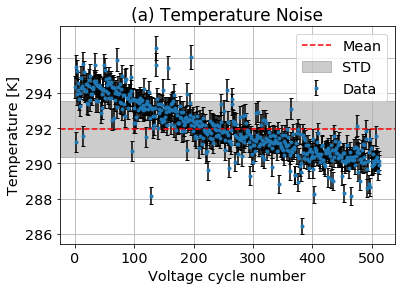

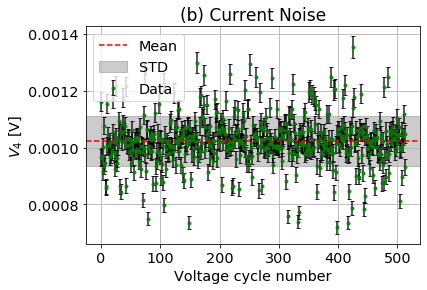

In [31]:
#plotting V4 vs temp to get big resistance as V=IR 
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
# 'figure.figsize': (6, 6),

dataNoise = np.transpose((np.loadtxt('Data/2020-02-24 14_17 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))
dataNoise_err = ErrOnVoltage(dataNoise)

TempErr_dataNoise = [getTempFromVolt_Err(dataNoise[7][i]*1e3, dataNoise_err[7][i]*1e3) for i in range(0, len(dataNoise[0])) ]
TempErr_dataNoise = np.transpose(TempErr_dataNoise)

count = np.linspace(0, len(TempErr_dataNoise[0]), len(TempErr_dataNoise[0]))
# plt.plot(tempDataLower, dataLower[6], ls=" ", marker=".")

plt.errorbar(count, TempErr_dataNoise[0], yerr=TempErr_dataNoise[1], ls=" ", marker=".", label="Data", ecolor='black', capsize=2)#, alpha=0.85)
plt.axhline(291.969788470442, color="r", ls="--", label="Mean")
plt.axhspan(291.96 - 1.5886, 291.96 + 1.5886, alpha=0.2, color='black', label='STD')
plt.grid()
plt.xlabel("Voltage cycle number")
plt.ylabel("Temperature [K]")
plt.title("(a) Temperature Noise", size=17)
plt.legend()

plt.show()

plt.errorbar(count, dataNoise[3], yerr=dataNoise_err[3], ls=" ", marker=".", label="Data", ecolor='black', capsize=2, color="green", alpha=0.85)
plt.axhline(0.0010219, color="r", ls="--", label="Mean")
plt.axhspan(0.0010219 - 8.820e-05, 0.0010219 + 8.820e-05, alpha=0.2, color='black', label='STD')


plt.grid()
plt.xlabel("Voltage cycle number")
plt.ylabel("$V_4$ [V]")
plt.title("(b) Current Noise", size=17)
plt.legend()

plt.show()

In [10]:
#Get deviation of temp for error
# TempErr_dataNoise[0], yerr=TempErr_dataNoise[1]

print(np.mean(TempErr_dataNoise[1]))

print(np.mean(TempErr_dataNoise[0]))

STD = np.std(TempErr_dataNoise[0])#/np.sqrt(len(TempErr_dataNoise[0]))
print(STD)

0.5805950955974318
291.969788470442
1.5886494448368644


In [92]:

meanV = np.mean(dataNoise[3])
print(meanV)

STD = np.std(dataNoise[3])#/np.sqrt(len(TempErr_dataNoise[0]))
print(STD)
print(STD/np.sqrt(len(dataNoise[3])))

R = meanV/0.001
#error on I
STD_I = STD/R
print(STD_I)

0.0010219460038986357
8.820646825225487e-05
3.894410710084737e-06
8.631225907802841e-05


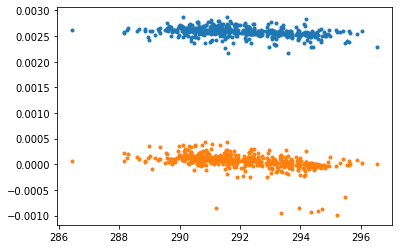

In [54]:
plt.plot(TempErr_dataNoise[0], dataNoise[1], ls=" ", marker=".")
plt.plot(TempErr_dataNoise[0], dataNoise[0], ls=" ", marker=".")

plt.show()